![alt text](<Screenshot 2024-12-24 195710.png>)

In [60]:
import sklearn

# Prepare the dataset

In [61]:
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples, noise=0.05, random_state=42)

In [62]:
len(X), len(y)

(1000, 1000)

In [63]:
X[:5], y[:5]

(array([[ 0.74220688,  0.24668576],
        [-0.7340323 ,  0.16869164],
        [-0.82985872,  0.22195899],
        [-0.42913559,  0.67223019],
        [ 0.44560223, -0.89493556]]),
 array([1, 1, 1, 1, 0], dtype=int64))

In [64]:
import pandas as pd

circles = pd.DataFrame({'X1': X[:, 0], # all of the rows in the first column
                        'X2' : X[:, 1], # all of the rows in the second column
                        'label' : y})

In [65]:
circles.head(10)

,X1,X2,label
0,0.742207,0.246686,1
1,-0.734032,0.168692,1
2,-0.829859,0.221959,1
3,-0.429136,0.672230,1
4,0.445602,-0.894936,0
5,-0.469885,0.708037,1
6,-0.016045,0.805623,1
7,0.759623,0.159526,1
8,-0.175692,-0.799837,1
9,-0.110616,1.042207,0


In [66]:
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

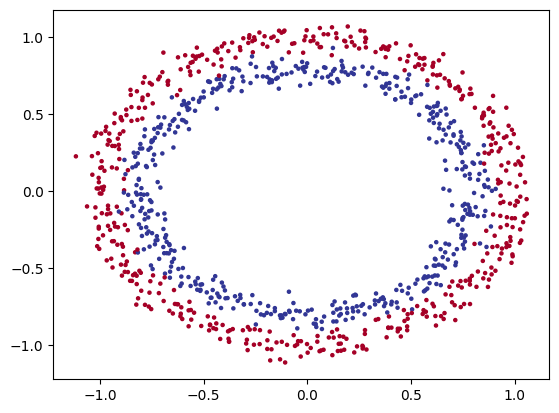

In [67]:
#visualization

import matplotlib.pyplot as plt

plt.scatter(x= X[:,0], y=X[:, 1], c=y, s=5, cmap = plt.cm.RdYlBu)


In [68]:
X.shape, y.shape

((1000, 2), (1000,))

In [69]:
import torch
print(torch.__version__)

type(X), X.dtype

# data to tensors
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

2.5.1+cu118


In [70]:
type(X), X.dtype

(torch.Tensor, torch.float32)

In [71]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42
                                                    )

In [72]:
len(X_train), len(y_train) , len(X_test), len(y_test) 

(800, 800, 200, 200)

# building the model


In [73]:
import torch
from torch import nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [74]:
# costrcut model with two linear layers using class method

class CircleModelV0(nn.Module):
    def __init__(self):
        super(CircleModelV0, self).__init__()
        self.layer1=nn.Linear(2, 5)
        self.layer2 = nn.Linear(5, 1)

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.layer2(self.layer1(x))

model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [75]:
# other method using sequential model

model_0 = nn.Sequential(
    nn.Linear(2,5),
    nn.Linear(5,1),
    ).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [76]:
untrained_preds = model_0(X_test.to(device))
print(f'this is the shape of the untrained model predictions : {untrained_preds.shape}')
print(f'this is the real target shape : {y_test.shape}')

this is the shape of the untrained model predictions : torch.Size([200, 1])
this is the real target shape : torch.Size([200])


In [77]:
# this is an exampl of the logits, logits are the output of the neural network bfore the activation function
untrained_preds[:5] , y_test[:5]

(tensor([[-0.0307],
         [-0.0213],
         [ 0.0896],
         [-0.0678],
         [ 0.3020]], device='cuda:0', grad_fn=<SliceBackward0>),
 tensor([1., 0., 1., 0., 1.]))

In [78]:
# refer to pytorch documentation

"""
this is and example for a classifiaction problem that is binary classification (0,1)

calssificationproblem loss functions are:

1. BCEloss() -> binary classification 
2. BCEWithLogicLoss() -> binary classification -> (sigmoid(), BCEloss()) -> we choose this because its numerically stable
        nn.Sequential(nn.Sigmoid(), nn.BCELoss())
3. CategoricalCrossEntropy() -> multicalss classification
"""

'\nthis is and example for a classifiaction problem that is binary classification (0,1)\n\ncalssificationproblem loss functions are:\n\n1. BCEloss() -> binary classification \n2. BCEWithLogicLoss() -> binary classification -> (sigmoid(), BCEloss()) -> we choose this because its numerically stable\n        nn.Sequential(nn.Sigmoid(), nn.BCELoss())\n3. CategoricalCrossEntropy() -> multicalss classification\n'

In [79]:
loss_fn= nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params = model_0.parameters(), lr = 0.01)

In [80]:
# what is happening with the activation function

random_tensor = torch.tensor([-100, -0.5,-1,-0.3, 1 , 5,100])
sigmoid_outpout = torch.sigmoid(random_tensor)
sigmoid_outpout

tensor([0.0000, 0.3775, 0.2689, 0.4256, 0.7311, 0.9933, 1.0000])

In [81]:
def accuracy_fn (y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() 
    acc = (correct/len(y_pred))*100
    return acc

In [82]:
x_p = torch.tensor([1,1,1,1,1])
x_t = torch.tensor([1,0,1,0,1])

accuracy_fn(y_true=x_t,  y_pred= x_p)

60.0

# So to sum this up we have a few steps to consider
1. logits -> preds prob -> round preds labels
2. binary classification we use sigmoid
3. multi class classification we use softmax

# Let's Construct a training loop 

Steps

1. Forward pass
2. calculate the loss
3. optimizer zero grad
4. loss backward()
5. optimizer.step()

In [83]:
device

'cuda'

In [84]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)


# set the number of epochs
epochs = 100

# put the data in the taget device -> 'cuda

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)


In [85]:
# build the training loop and evaluation loop

for epoch in range(epochs):
    model_0.train()

    ###1. forward pass
    """the raw output of my model is calle logits"""
    y_logits = model_0(X_train).squeeze()
    """from logits -> pred prob -> pred class labels"""
    y_pred = torch.round(torch.sigmoid(y_logits)) 
    # used round cause we need to comapre in the accuracy function with intger values not float values

    ### 2. calculate the loss
    """BCEWithLogicLoss()"""
    loss = loss_fn(y_logits, y_train)

    acc = accuracy_fn(y_true = y_train, y_pred=y_pred)

    ###  3. optimizer zero grad
    optimizer.zero_grad()
    
    ###  4. loss backward()
    loss.backward()

    ###  5. optimizer.step()
    optimizer.step()

    ### Testing
    model_0.eval()

    with torch.inference_mode():
        # 1. forward pass
        test_logits = model_0(X_test).squeeze()

        test_pred = torch.round(torch.sigmoid(test_logits)) 
        """from logits -> pred prob -> pred class labels"""

        # 2. Calculate loss
        test_loss = loss_fn(test_logits, y_test)

        test_acc = accuracy_fn(y_true =y_test, y_pred = test_pred) 

    # logging .. print what happened

    if epoch %10 == 0:
        print(f"Epoch : {epoch} | Train Loss : {loss:.5f} | Train Accuracy : {acc:.2f} | Test Loss : {test_loss:.5f} | Test Accuracy : {test_acc:.2f}")

Epoch : 0 | Train Loss : 0.69802 | Train Accuracy : 52.25 | Test Loss : 0.69452 | Test Accuracy : 57.50
Epoch : 10 | Train Loss : 0.69774 | Train Accuracy : 52.00 | Test Loss : 0.69431 | Test Accuracy : 58.00
Epoch : 20 | Train Loss : 0.69747 | Train Accuracy : 52.00 | Test Loss : 0.69411 | Test Accuracy : 57.50
Epoch : 30 | Train Loss : 0.69723 | Train Accuracy : 51.62 | Test Loss : 0.69394 | Test Accuracy : 56.50
Epoch : 40 | Train Loss : 0.69700 | Train Accuracy : 51.50 | Test Loss : 0.69378 | Test Accuracy : 56.50
Epoch : 50 | Train Loss : 0.69679 | Train Accuracy : 51.88 | Test Loss : 0.69363 | Test Accuracy : 56.50
Epoch : 60 | Train Loss : 0.69660 | Train Accuracy : 51.50 | Test Loss : 0.69350 | Test Accuracy : 56.00
Epoch : 70 | Train Loss : 0.69642 | Train Accuracy : 51.00 | Test Loss : 0.69338 | Test Accuracy : 56.00
Epoch : 80 | Train Loss : 0.69626 | Train Accuracy : 51.00 | Test Loss : 0.69327 | Test Accuracy : 55.00
Epoch : 90 | Train Loss : 0.69610 | Train Accuracy : 51.

In [86]:
import requests
from pathlib import Path

# create utils directory
utils_dir = Path("utils")
utils_dir.mkdir(parents = True, exist_ok=True)

# downloading the helper function script function from github

if (utils_dir  / "helper_functions.py").is_file():
    print("helper function alreday exists skipping download of helper function")
else:
    print("Downlodding helper functions.py")
    request = requests.get("https://raw.githubusercontent.com/Amr-Abdellatif/learn-deep-learning-using-pytorch/refs/heads/main/helper_functions.py")
    with open(utils_dir / "helper_functions.py", "wb") as f:
        f.write(request.content)

# https://raw.githubusercontent.com/Amr-Abdellatif/learn-deep-learning-using-pytorch/refs/heads/main/helper_functions.py

helper function alreday exists skipping download of helper function


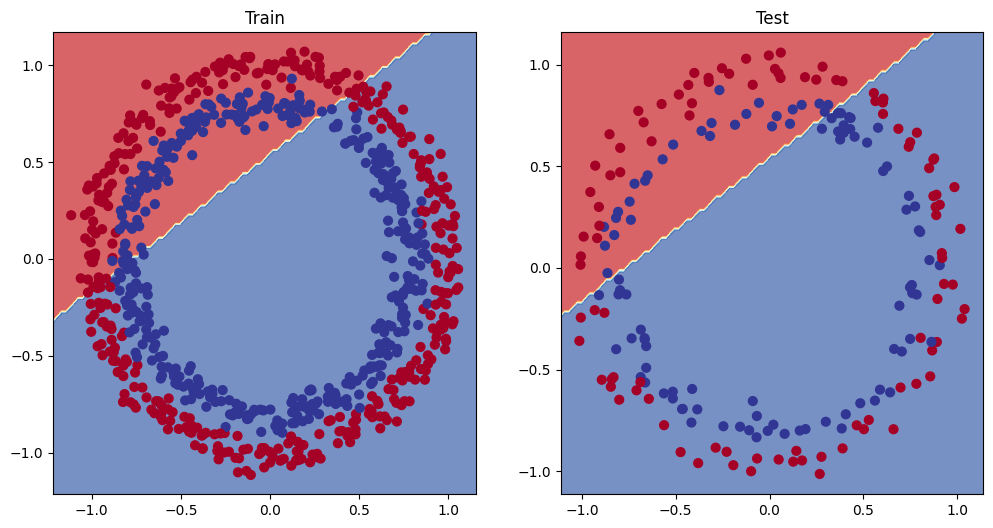

In [87]:
from helper_functions import plot_decision_boundary, plot_predictions

# plot decision boundaries for training and testing set

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)

plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)


In [88]:
# try to imovrove the model by addding one layer 

class CircleModelV1(nn.Module):
    def __init__(self):
        super(CircleModelV1, self).__init__()
        self.layer1=nn.Linear(2, 10)
        self.layer2 = nn.Linear(10, 20)
        self.layer3 = nn.Linear(20,1)
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.layer3(self.layer2(self.layer1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=20, bias=True)
  (layer3): Linear(in_features=20, out_features=1, bias=True)
)

In [89]:
loss_fn= nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params = model_1.parameters(), lr = 0.01)

In [90]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)


# set the number of epochs
epochs = 100

# put the data in the taget device -> 'cuda

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)


# build the training loop and evaluation loop

for epoch in range(epochs):
    model_1.train()

    ###1. forward pass
    """the raw output of my model is calle logits"""
    y_logits = model_1(X_train).squeeze()
    """from logits -> pred prob -> pred class labels"""
    y_pred = torch.round(torch.sigmoid(y_logits)) 
    # used round cause we need to comapre in the accuracy function with intger values not float values

    ### 2. calculate the loss
    """BCEWithLogicLoss()"""
    loss = loss_fn(y_logits, y_train)

    acc = accuracy_fn(y_true = y_train, y_pred=y_pred)

    ###  3. optimizer zero grad
    optimizer.zero_grad()
    
    ###  4. loss backward()
    loss.backward()

    ###  5. optimizer.step()
    optimizer.step()

    ### Testing
    model_1.eval()

    with torch.inference_mode():
        # 1. forward pass
        test_logits = model_1(X_test).squeeze()

        test_pred = torch.round(torch.sigmoid(test_logits)) 
        """from logits -> pred prob -> pred class labels"""

        # 2. Calculate loss
        test_loss = loss_fn(test_logits, y_test)

        test_acc = accuracy_fn(y_true =y_test, y_pred = test_pred) 

    # logging .. print what happened

    if epoch %10 == 0:
        print(f"Epoch : {epoch} | Train Loss : {loss:.5f} | Train Accuracy : {acc:.2f} | Test Loss : {test_loss:.5f} | Test Accuracy : {test_acc:.2f}")

Epoch : 0 | Train Loss : 0.69456 | Train Accuracy : 51.38 | Test Loss : 0.69738 | Test Accuracy : 50.00
Epoch : 10 | Train Loss : 0.69440 | Train Accuracy : 52.00 | Test Loss : 0.69724 | Test Accuracy : 49.50
Epoch : 20 | Train Loss : 0.69427 | Train Accuracy : 51.75 | Test Loss : 0.69711 | Test Accuracy : 48.50
Epoch : 30 | Train Loss : 0.69415 | Train Accuracy : 51.00 | Test Loss : 0.69701 | Test Accuracy : 48.00
Epoch : 40 | Train Loss : 0.69406 | Train Accuracy : 51.12 | Test Loss : 0.69692 | Test Accuracy : 47.50
Epoch : 50 | Train Loss : 0.69397 | Train Accuracy : 51.00 | Test Loss : 0.69684 | Test Accuracy : 48.50
Epoch : 60 | Train Loss : 0.69390 | Train Accuracy : 50.88 | Test Loss : 0.69677 | Test Accuracy : 48.50
Epoch : 70 | Train Loss : 0.69384 | Train Accuracy : 51.25 | Test Loss : 0.69671 | Test Accuracy : 48.50
Epoch : 80 | Train Loss : 0.69378 | Train Accuracy : 51.25 | Test Loss : 0.69666 | Test Accuracy : 50.00
Epoch : 90 | Train Loss : 0.69374 | Train Accuracy : 51.

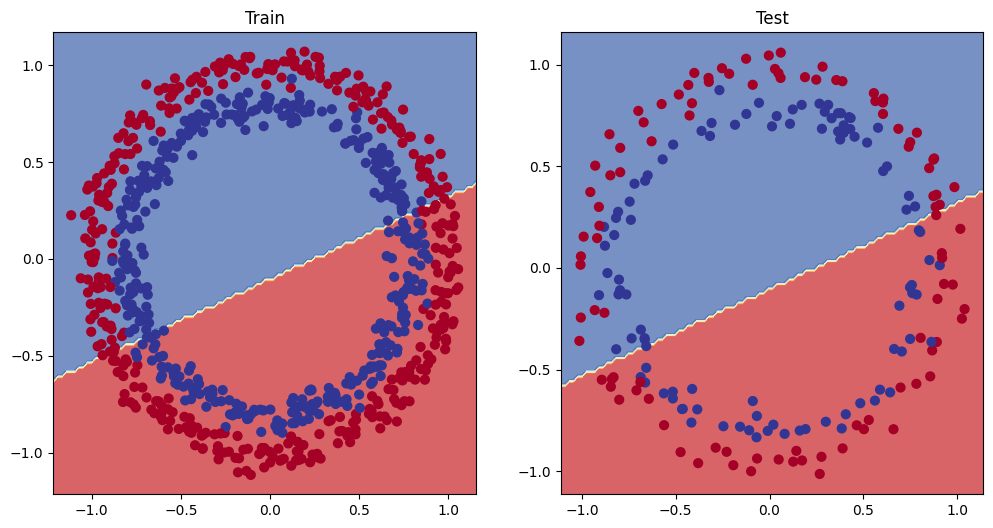

In [91]:
from helper_functions import plot_decision_boundary, plot_predictions

# plot decision boundaries for training and testing set

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)

plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)


# No improvment which mean stacking more layers is not supporting to increate the model accuracy

So we need to introduce non linearity through the activation function

In [98]:
# build model with activation function

class CircleModelV2(nn.Module):
    def __init__(self):
        super(CircleModelV2, self).__init__()
        self.layer1=nn.Linear(2, 10)
        self.layer2 = nn.Linear(10, 10)
        self.layer3 = nn.Linear(10,1)
        self.relu = nn.ReLU()
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

model_2 = CircleModelV2().to(device)
model_2

CircleModelV2(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [99]:
loss_fn= nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params = model_2.parameters(), lr = 1)

In [101]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)


# set the number of epochs
epochs = 400

# put the data in the taget device -> 'cuda

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)


# build the training loop and evaluation loop

for epoch in range(epochs):
    model_2.train()

    ###1. forward pass
    """the raw output of my model is calle logits"""
    y_logits = model_2(X_train).squeeze()
    """from logits -> pred prob -> pred class labels"""
    y_pred = torch.round(torch.sigmoid(y_logits)) 
    # used round cause we need to comapre in the accuracy function with intger values not float values

    ### 2. calculate the loss
    """BCEWithLogicLoss()"""
    loss = loss_fn(y_logits, y_train)

    acc = accuracy_fn(y_true = y_train, y_pred=y_pred)

    ###  3. optimizer zero grad
    optimizer.zero_grad()
    
    ###  4. loss backward()
    loss.backward()

    ###  5. optimizer.step()
    optimizer.step()

    ### Testing
    model_2.eval()

    with torch.inference_mode():
        # 1. forward pass
        test_logits = model_2(X_test).squeeze()

        test_pred = torch.round(torch.sigmoid(test_logits)) 
        """from logits -> pred prob -> pred class labels"""

        # 2. Calculate loss
        test_loss = loss_fn(test_logits, y_test)

        test_acc = accuracy_fn(y_true =y_test, y_pred = test_pred) 

    # logging .. print what happened

    if epoch %10 == 0:
        print(f"Epoch : {epoch} | Train Loss : {loss:.5f} | Train Accuracy : {acc:.2f} | Test Loss : {test_loss:.5f} | Test Accuracy : {test_acc:.2f}")

Epoch : 0 | Train Loss : 0.49083 | Train Accuracy : 81.75 | Test Loss : 0.52842 | Test Accuracy : 79.00
Epoch : 10 | Train Loss : 0.53157 | Train Accuracy : 76.50 | Test Loss : 0.50287 | Test Accuracy : 83.50
Epoch : 20 | Train Loss : 0.59554 | Train Accuracy : 59.50 | Test Loss : 1.28530 | Test Accuracy : 50.00
Epoch : 30 | Train Loss : 0.35219 | Train Accuracy : 96.38 | Test Loss : 0.38264 | Test Accuracy : 90.50
Epoch : 40 | Train Loss : 0.52696 | Train Accuracy : 65.62 | Test Loss : 1.03771 | Test Accuracy : 50.00
Epoch : 50 | Train Loss : 0.53607 | Train Accuracy : 89.12 | Test Loss : 0.51355 | Test Accuracy : 87.50
Epoch : 60 | Train Loss : 0.50520 | Train Accuracy : 86.88 | Test Loss : 0.47783 | Test Accuracy : 89.50
Epoch : 70 | Train Loss : 0.38426 | Train Accuracy : 94.00 | Test Loss : 0.38176 | Test Accuracy : 87.00
Epoch : 80 | Train Loss : 0.26377 | Train Accuracy : 96.38 | Test Loss : 0.30563 | Test Accuracy : 94.00
Epoch : 90 | Train Loss : 0.39260 | Train Accuracy : 90.

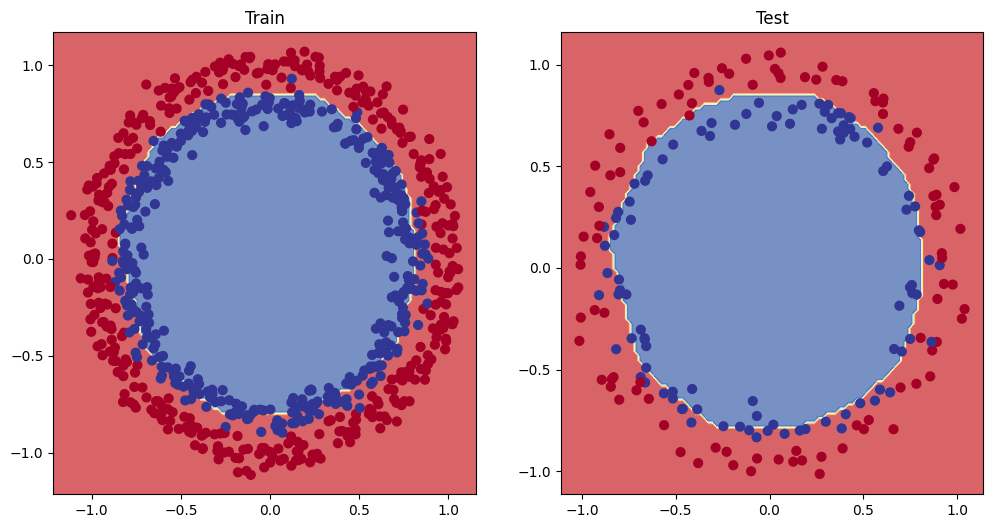

In [102]:
from helper_functions import plot_decision_boundary, plot_predictions

# plot decision boundaries for training and testing set

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_2, X_train, y_train)

plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_2, X_test, y_test)


# Explaination of ReLu FUNCTION 
which comapre values and return the bigger one 

In [103]:
x = torch.linspace(-15,15,100)
x

tensor([-15.0000, -14.6970, -14.3939, -14.0909, -13.7879, -13.4848, -13.1818,
        -12.8788, -12.5758, -12.2727, -11.9697, -11.6667, -11.3636, -11.0606,
        -10.7576, -10.4545, -10.1515,  -9.8485,  -9.5455,  -9.2424,  -8.9394,
         -8.6364,  -8.3333,  -8.0303,  -7.7273,  -7.4242,  -7.1212,  -6.8182,
         -6.5152,  -6.2121,  -5.9091,  -5.6061,  -5.3030,  -5.0000,  -4.6970,
         -4.3939,  -4.0909,  -3.7879,  -3.4848,  -3.1818,  -2.8788,  -2.5758,
         -2.2727,  -1.9697,  -1.6667,  -1.3636,  -1.0606,  -0.7576,  -0.4545,
         -0.1515,   0.1515,   0.4545,   0.7576,   1.0606,   1.3636,   1.6667,
          1.9697,   2.2727,   2.5758,   2.8788,   3.1818,   3.4848,   3.7879,
          4.0909,   4.3939,   4.6970,   5.0000,   5.3030,   5.6061,   5.9091,
          6.2121,   6.5152,   6.8182,   7.1212,   7.4242,   7.7273,   8.0303,
          8.3333,   8.6364,   8.9394,   9.2424,   9.5455,   9.8485,  10.1515,
         10.4545,  10.7576,  11.0606,  11.3636,  11.6667,  11.96

In [104]:
def relu(x):
    return torch.max(torch.tensor(0),x)

y = relu(x)
y 

tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.1515,  0.4545,  0.7576,  1.0606,  1.3636,  1.6667,
         1.9697,  2.2727,  2.5758,  2.8788,  3.1818,  3.4848,  3.7879,  4.0909,
         4.3939,  4.6970,  5.0000,  5.3030,  5.6061,  5.9091,  6.2121,  6.5152,
         6.8182,  7.1212,  7.4242,  7.7273,  8.0303,  8.3333,  8.6364,  8.9394,
         9.2424,  9.5455,  9.8485, 10.1515, 10.4545, 10.7576, 11.0606, 11.3636,
        11.6667, 11.9697, 12.2727, 12.5758, 12.8788, 13.1818, 13.4848, 13.7879,
        14.0909, 14.3939, 14.6970, 15.00

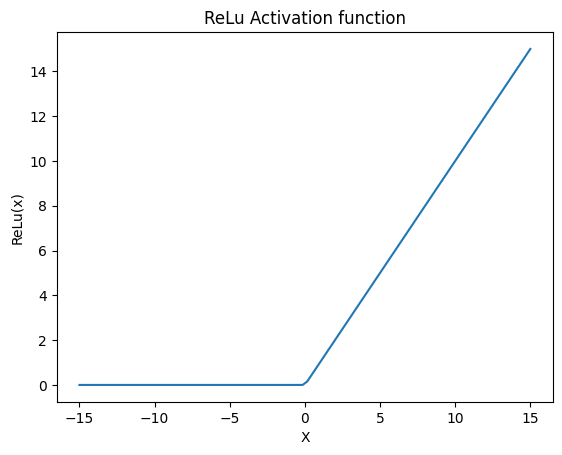

In [105]:
plt.plot(x.numpy(), y.numpy())
plt.title("ReLu Activation function")
plt.xlabel("X")
plt.ylabel("ReLu(x)")
plt.show()

# Tanh FUNCTION 

In [106]:
def tanh(x):
    return(torch.exp(x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-x))

y = tanh(x)
y

tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -0.9999, -0.9998, -0.9997, -0.9994, -0.9990, -0.9981, -0.9966,
        -0.9937, -0.9885, -0.9790, -0.9618, -0.9311, -0.8772, -0.7859, -0.6396,
        -0.4256, -0.1504,  0.1504,  0.4256,  0.6396,  0.7859,  0.8772,  0.9311,
         0.9618,  0.9790,  0.9885,  0.9937,  0.9966,  0.9981,  0.9990,  0.9994,
         0.9997,  0.9998,  0.9999,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.00

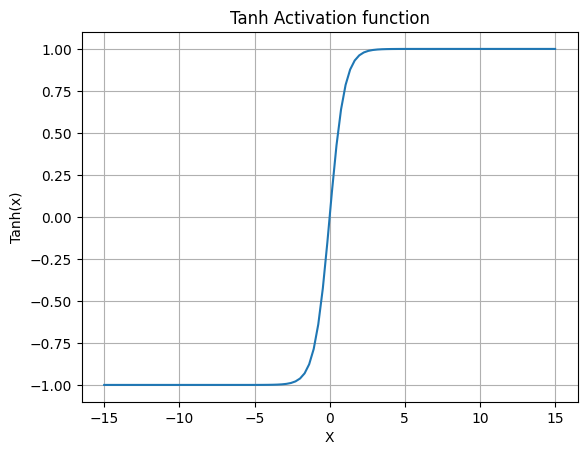

In [107]:
plt.plot(x.numpy(), y.numpy())
plt.title("Tanh Activation function")
plt.xlabel("X")
plt.ylabel("Tanh(x)")
plt.grid(True)
plt.show()

# Sigmoid function

In [108]:
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

x = torch.linspace(-15,15,100)
y = sigmoid(x)
y

tensor([3.0590e-07, 4.1418e-07, 5.6078e-07, 7.5927e-07, 1.0280e-06, 1.3919e-06,
        1.8846e-06, 2.5516e-06, 3.4547e-06, 4.6776e-06, 6.3332e-06, 8.5749e-06,
        1.1610e-05, 1.5719e-05, 2.1283e-05, 2.8816e-05, 3.9015e-05, 5.2824e-05,
        7.1521e-05, 9.6833e-05, 1.3110e-04, 1.7750e-04, 2.4031e-04, 3.2534e-04,
        4.4045e-04, 5.9626e-04, 8.0714e-04, 1.0925e-03, 1.4786e-03, 2.0010e-03,
        2.7073e-03, 3.6621e-03, 4.9518e-03, 6.6929e-03, 9.0404e-03, 1.2201e-02,
        1.6449e-02, 2.2142e-02, 2.9746e-02, 3.9856e-02, 5.3212e-02, 7.0715e-02,
        9.3407e-02, 1.2242e-01, 1.5887e-01, 2.0365e-01, 2.5719e-01, 3.1917e-01,
        3.8828e-01, 4.6219e-01, 5.3781e-01, 6.1172e-01, 6.8083e-01, 7.4281e-01,
        7.9635e-01, 8.4113e-01, 8.7758e-01, 9.0659e-01, 9.2928e-01, 9.4679e-01,
        9.6014e-01, 9.7025e-01, 9.7786e-01, 9.8355e-01, 9.8780e-01, 9.9096e-01,
        9.9331e-01, 9.9505e-01, 9.9634e-01, 9.9729e-01, 9.9800e-01, 9.9852e-01,
        9.9891e-01, 9.9919e-01, 9.9940e-

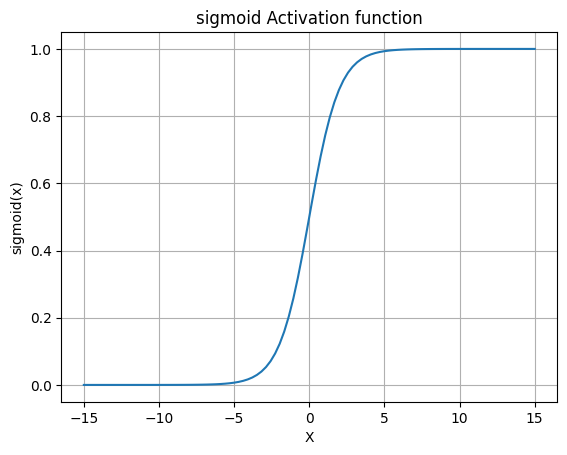

In [109]:
plt.plot(x.numpy(), y.numpy())
plt.title("sigmoid Activation function")
plt.xlabel("X")
plt.ylabel("sigmoid(x)")
plt.grid(True)
plt.show()